In [3]:
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_rm_yields = pd.read_csv(r'C:\Users\Administrator\Desktop\jupytar\rm yeild\rm-yields-data (1).csv')
df_agg_00_23 = pd.read_csv(r'C:\Users\Administrator\Desktop\jupytar\final project\rm_yield_00_23_major_crops.csv')
gdf_rm = gpd.read_file(r'C:\Users\Administrator\Desktop\jupytar\final project\RM_shapefile\RuralMunicipality.shp')

df_rm_yields.isna().sum()

Year                0
RM                  0
Winter Wheat    22503
Canola          11019
Spring Wheat      109
Mustard         20927
Durum           13681
Sunflowers      24661
Oats             1259
Lentils         19700
Peas            16904
Barley            335
Fall Rye         9693
Canary Seed     21666
Spring Rye      24802
Tame Hay        21402
Flax             4297
Chickpeas       24311
dtype: int64

In [6]:
# Clean and preprocess GIS data
gdf_rm['RMNO'] = gdf_rm['RMNO'].astype(int)
gdf_rm_clean = gdf_rm[['RMNO', 'geometry']].rename(columns={'RMNO': 'RM'})

# Filter and prepare the main dataset
df_major_crops = df_rm_yields[['Year', 'RM', 'Canola', 'Spring Wheat']]
df_00_23 = df_major_crops[(df_major_crops['Year'] >= 2000)]

# Check for missing values
print(df_00_23.isna().sum())

# Drop rows with missing values for simplicity 
df_00_23 = df_00_23.dropna()

Year              0
RM                0
Canola          283
Spring Wheat     92
dtype: int64


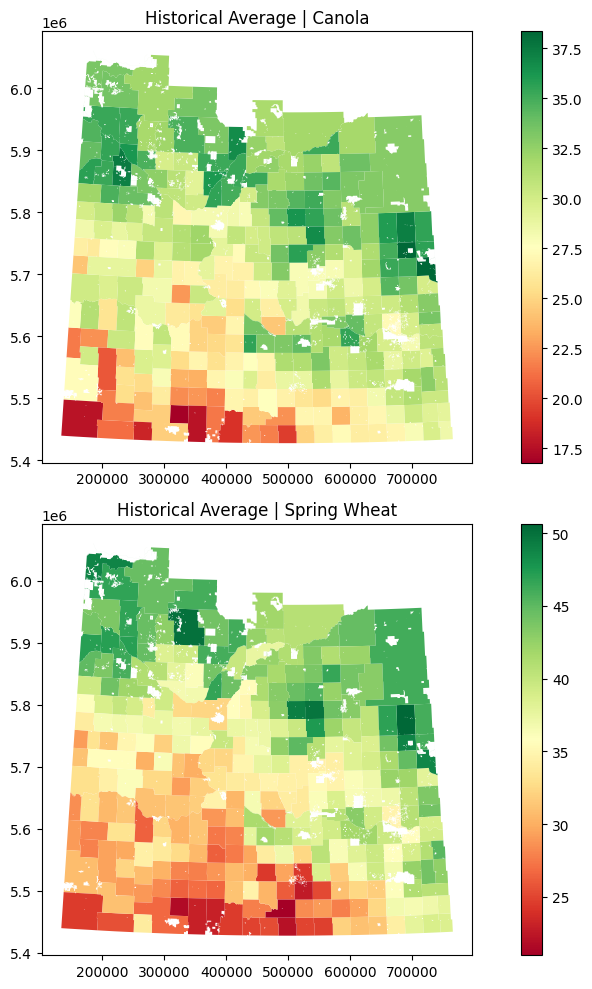

In [9]:
merged_df = pd.merge(
    gdf_rm_clean.rename(columns={'RMNO': 'RM'}),
    df_00_23.groupby('RM').mean(),
    on='RM'
)

# List of crops
crops = ['Canola', 'Spring Wheat']

# Create a subplot for each crop
fig, axes = plt.subplots(nrows=len(crops), figsize=(10, 5 * len(crops)))

# Plot each crop
for i, crop in enumerate(crops):
    merged_df.plot(column=crop, cmap='RdYlGn', legend=True, ax=axes[i])
    axes[i].set_title(f'Historical Average | {crop}')

plt.tight_layout()
plt.show()

In [30]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor



# Feature Engineering
X = df_00_23[['Year', 'RM']].values
y_canola = df_00_23['Canola'].values
y_spring_wheat = df_00_23['Spring Wheat'].values

# Data Preparation
X_train, X_test, y_canola_train, y_canola_test = \
    train_test_split(X, y_canola, test_size=0.2, random_state=42)
_, _, y_spring_wheat_train, y_spring_wheat_test = \
    train_test_split(X, y_spring_wheat, test_size=0.2, random_state=42)

# Hyperparameter Tuning (XGBoost for Canola)
param_grid_canola = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

xgb_canola = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_canola = GridSearchCV(xgb_canola, param_grid_canola, cv=5, scoring='neg_mean_squared_error')
grid_search_canola.fit(X_train, y_canola_train)
best_xgb_canola = grid_search_canola.best_estimator_

# Hyperparameter Tuning (XGBoost for Spring Wheat)
param_grid_spring_wheat = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

xgb_spring_wheat = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_spring_wheat = GridSearchCV(xgb_spring_wheat, param_grid_spring_wheat, cv=5, scoring='neg_mean_squared_error')
grid_search_spring_wheat.fit(X_train, y_spring_wheat_train)
best_xgb_spring_wheat = grid_search_spring_wheat.best_estimator_

# Predictions
y_canola_pred = best_xgb_canola.predict(X_test)
y_spring_wheat_pred = best_xgb_spring_wheat.predict(X_test)

# Model Evaluation
mse_canola = mean_squared_error(y_canola_test, y_canola_pred)
mse_spring_wheat = mean_squared_error(y_spring_wheat_test, y_spring_wheat_pred)

print("MSE for Canola (XGBoost):", mse_canola)
print("MSE for Spring Wheat (XGBoost):", mse_spring_wheat)


MSE for Canola (XGBoost): 19.569896565066166
MSE for Spring Wheat (XGBoost): 29.578288160090665


Mean Squared Error (MSE) for predicted canola yields: 6.317233633341726


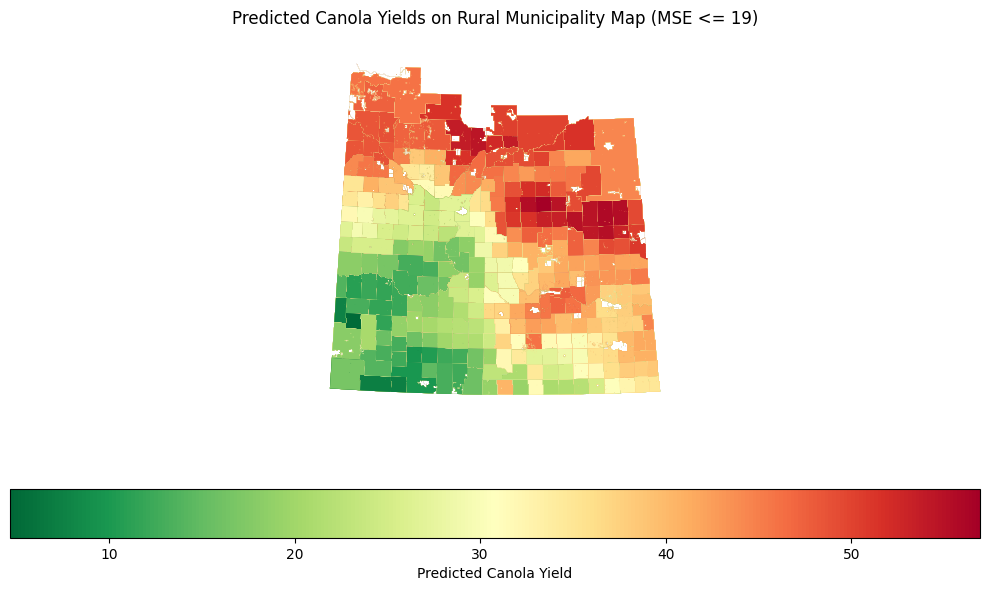

In [34]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_canola, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
rf_model_canola = RandomForestRegressor()
rf_model_canola.fit(X_train[:, :2], y_train)

# Predict canola yield for all rural municipalities
all_canola_predictions_rf = rf_model_canola.predict(X[:, :2])  # Assuming 'Year' and 'RM' are the first two columns

# Calculate Mean Squared Error (MSE)
mse_canola = mean_squared_error(y_canola, all_canola_predictions_rf)
print("Mean Squared Error (MSE) for predicted canola yields:", mse_canola)

# Create DataFrame with predicted canola yields for all RMs
all_canola_results_df = pd.DataFrame({
    'RM': X[:, 1],  # Rural Municipality
    'Predicted_Canola_Yield': all_canola_predictions_rf,  # Predicted canola yield using Random Forest
    'MSE': mse_canola  # Mean Squared Error
})

# Merge with GeoDataFrame to get geometries
merged_all_canola_df = pd.merge(gdf_rm_clean, all_canola_results_df, on='RM', how='inner')

# Filter out RMs with MSE greater than 19
filtered_canola_df = merged_all_canola_df[merged_all_canola_df['MSE'] <= 19]

# Plot predicted canola yield on map
fig, ax = plt.subplots(figsize=(10, 6))

# Plot predicted canola yield
filtered_canola_df.plot(column='Predicted_Canola_Yield', cmap='RdYlGn_r', legend=True, ax=ax,
                        legend_kwds={'label': "Predicted Canola Yield", 'orientation': "horizontal"})

# Add title and show the plot
plt.title('Predicted Canola Yields on Rural Municipality Map (MSE <= 19)')
plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()
















In [35]:
# Sort RMs based on predicted canola yields and select top 10
top_10_rm = merged_all_canola_df.nlargest(10, 'Predicted_Canola_Yield')

# Print the top 10 RMs
print("Top 10 Rural Municipalities for Canola Yield:")
print(top_10_rm)


Top 10 Rural Municipalities for Canola Yield:
       RM                                           geometry  \
3683  368  POLYGON ((556764.150 5806466.930, 556769.860 5...   
3182  369  POLYGON ((527416.390 5806204.640, 527420.890 5...   
3231  334  POLYGON ((675435.240 5782535.510, 675462.930 5...   
3183  369  POLYGON ((527416.390 5806204.640, 527420.890 5...   
596   333  POLYGON ((704805.750 5781237.710, 704839.540 5...   
1327  304  POLYGON ((676740.970 5751026.270, 676757.102 5...   
1229  336  POLYGON ((616906.880 5778393.840, 616923.530 5...   
4896  271  MULTIPOLYGON (((737210.570 5728213.560, 737219...   
4138  399  POLYGON ((527243.530 5835298.800, 527248.170 5...   
3682  368  POLYGON ((556764.150 5806466.930, 556769.860 5...   

      Predicted_Canola_Yield       MSE  
3683                 56.9380  6.317234  
3182                 55.7600  6.317234  
3231                 55.7470  6.317234  
3183                 55.4020  6.317234  
596                  55.3130  6.317234  
132

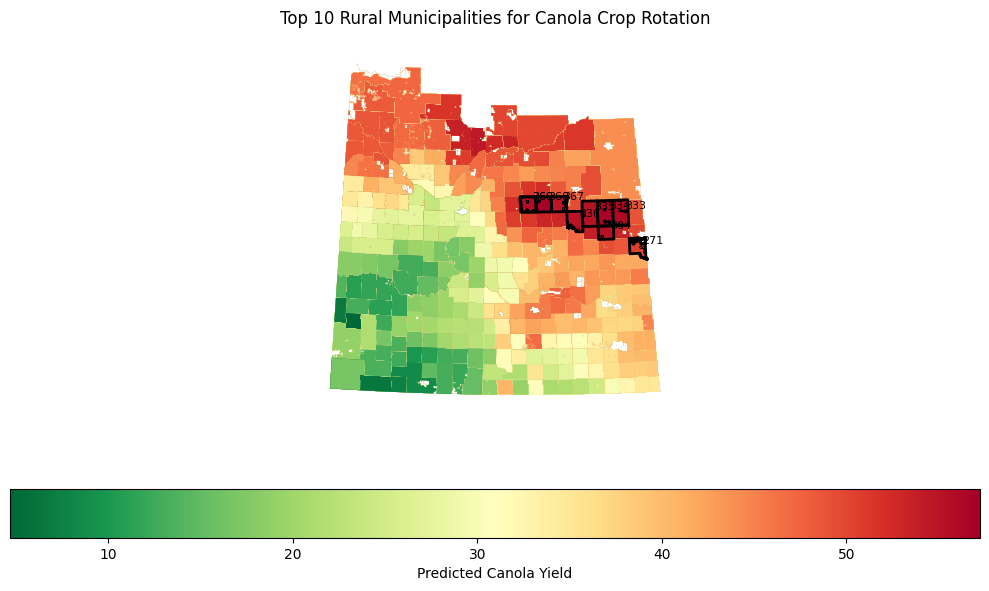

In [25]:
# Sort rural municipalities by predicted canola yield
top_rms_canola = merged_all_canola_df.sort_values(by='Predicted_Canola_Yield', ascending=False).head(10)

# Plot the top-ranked rural municipalities on the map
fig, ax = plt.subplots(figsize=(10, 6))

# Plot predicted canola yield for all rural municipalities
merged_all_canola_df.plot(column='Predicted_Canola_Yield', cmap='RdYlGn_r', legend=True, ax=ax,
                          legend_kwds={'label': "Predicted Canola Yield", 'orientation': "horizontal"})

# Plot the top-ranked rural municipalities
top_rms_canola.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# Annotate the top-ranked rural municipalities with their names
for x, y, label in zip(top_rms_canola.geometry.centroid.x, top_rms_canola.geometry.centroid.y, top_rms_canola['RM']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

# Add title and show the plot
plt.title('Top 10 Rural Municipalities for Canola Crop Rotation')
plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()


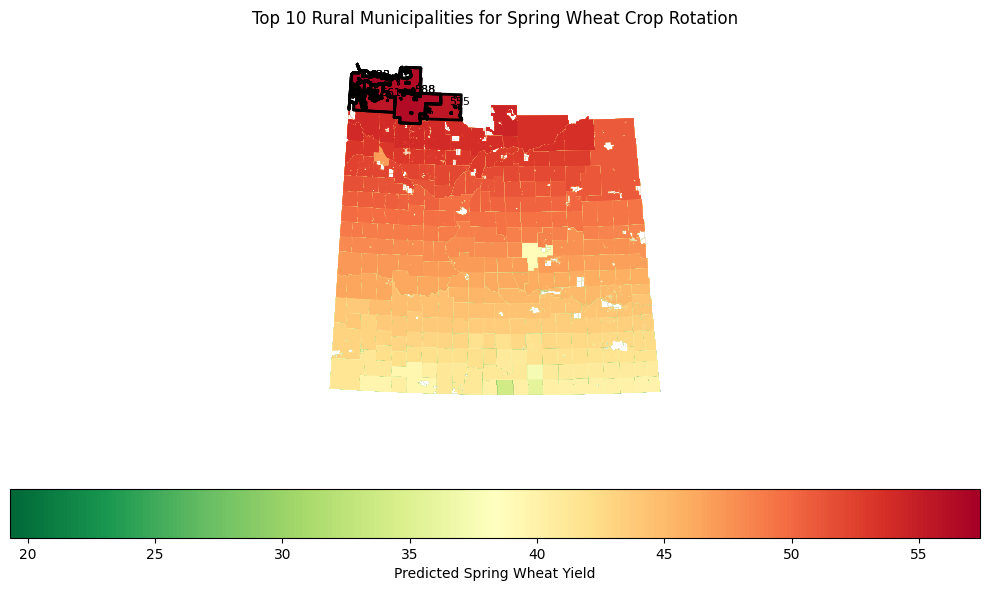

In [31]:
# Sort rural municipalities by predicted spring wheat yield
top_rms_spring_wheat = merged_all_spring_wheat_df.sort_values(by='Predicted_Spring_Wheat_Yield', ascending=False).head(10)

# Plot the top-ranked rural municipalities on the map
fig, ax = plt.subplots(figsize=(10, 6))

# Plot predicted spring wheat yield for all rural municipalities
merged_all_spring_wheat_df.plot(column='Predicted_Spring_Wheat_Yield', cmap='RdYlGn_r', legend=True, ax=ax,
                                legend_kwds={'label': "Predicted Spring Wheat Yield", 'orientation': "horizontal"})

# Plot the top-ranked rural municipalities
top_rms_spring_wheat.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# Annotate the top-ranked rural municipalities with their names
for x, y, label in zip(top_rms_spring_wheat.geometry.centroid.x, top_rms_spring_wheat.geometry.centroid.y, top_rms_spring_wheat['RM']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

# Add title and show the plot
plt.title('Top 10 Rural Municipalities for Spring Wheat Crop Rotation')
plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()



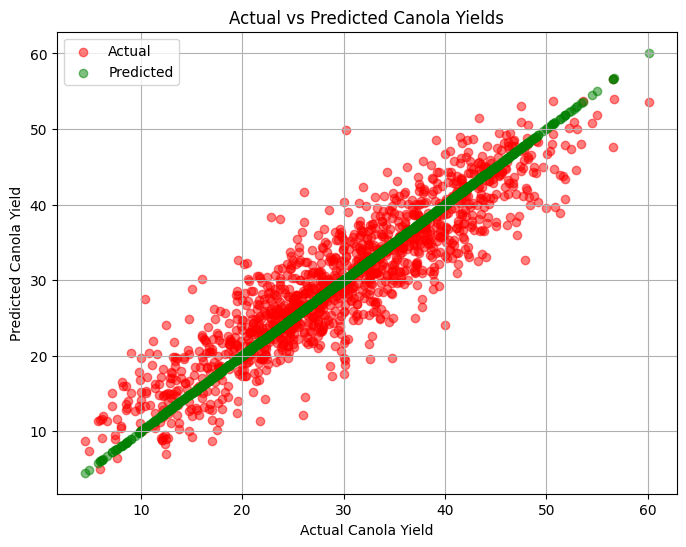

In [34]:
# Plot scatter plot of actual vs predicted canola yields with legend and colored points
plt.figure(figsize=(8, 6))
plt.scatter(canola_comparison_df['Actual_Canola_Yield'], canola_comparison_df['Predicted_Canola_Yield'], color='red', alpha=0.5, label='Actual')
plt.scatter(canola_comparison_df['Actual_Canola_Yield'], canola_comparison_df['Actual_Canola_Yield'], color='green', alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted Canola Yields')
plt.xlabel('Actual Canola Yield')
plt.ylabel('Predicted Canola Yield')
plt.grid(True)
plt.legend()
plt.show()

